In [107]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def BuildData(folder, sound_engine_name, date):

    # Get the list of files in the 'editor_data' folder
    folder_path = os.path.join(os.getcwd(), folder)
    file_list = os.listdir(folder_path)

    # Filter the files that contain 'CsoundUnity' in their names
    filtered_files = [file for file in file_list if sound_engine_name in file and date in file]

    # Initialize an empty DataFrame to store the merged data
    merged_df = pd.DataFrame()

    # Iterate over the filtered files and merge them into the DataFrame
    for file in filtered_files:
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)
        merged_df = pd.concat([merged_df, df])

    # Group the data by 'sources' column and assign contiguous group numbers
    grouped_df = merged_df.groupby(merged_df['sources'].ne(merged_df['sources'].shift()).cumsum())  

    def dataStats(field):
        # Initialize an empty DataFrame to store the results
        result_df = pd.DataFrame()
        # Iterate over the groups and calculate descriptive statistics
        for name, group in grouped_df:
            
            # Calculate descriptive statistics for the 'audio_frame_t_ms' column
            stats = group[field].describe()
            
            # Calculate the median
            median = group[field].median()
            
            # Create a new DataFrame with the source, audio_frame_t_ms, and descriptive statistics
            temp_df = pd.DataFrame({'sources': group['sources'].iloc[0],
                                    'count': stats['count'],
                                    'mean': stats['mean'],
                                    'std': stats['std'],
                                    'min': stats['min'],
                                    '25%': stats['25%'],
                                    '50%': stats['50%'],
                                    '75%': stats['75%'],
                                    'max': stats['max'],
                                    'median': median}, index=[0])
            
            # Append the temporary DataFrame to the result DataFrame
            result_df = pd.concat([result_df, temp_df], ignore_index=True)

        # return the result DataFrame
        return result_df
    
    return dataStats('audio_frame_t_ms'), dataStats('audio_memory_mb')

def Plot(dataPerSources, sound_engine_name, title, yLabel, xlabel = 'Number of Audio Sources', marker = 'o-', color='blue', ecolor='orange', drawBufferLimit = False):

    # Set the x-axis values as the index of the dataframe
    x = dataPerSources.index

    # Set the y-axis values as the mean values from the 'mean' column
    y = dataPerSources['mean']

    # Plot the data
    #plt.plot(x, y, color='blue', marker='o', linestyle='-', label='Mean')

    # Set the x-axis values as the index of the dataframe
    x = dataPerSources.index

    # Set the y-axis values as the mean values from the 'mean' column
    y = dataPerSources['mean']

    # Set the y-axis error values as the standard deviation values from the 'std' column
    y_error = dataPerSources['std']

    # Plot the mean with error bars
    plt.errorbar(x, y, yerr=y_error, fmt=marker, label='Mean', color=color, ecolor=ecolor, elinewidth=1, capsize=3)

    if drawBufferLimit:
        # Set the y-coordinate of the horizontal line
        y_line = 21.33

        # Set the color of the horizontal line (configurable)
        line_color = 'green'

        # Add the horizontal line to the plot
        plt.axhline(y=y_line, color=line_color, label='_nolegend_')

        # Add the value to the left of the line
        plt.text(10, y_line - 0.6, 'Buffer Latency = ' + str(y_line) + ' ms', color=line_color, ha='right', va='center', fontsize=8)    
    

    # Set Title
    plt.title(title)

    # Set the x-axis label
    plt.xlabel(xlabel)
    # Set the y-axis label
    plt.ylabel(yLabel)

    # Set the x-axis ticks as the values in dataPerSources['sources']
    plt.xticks(x, dataPerSources['sources'])

    # Show the plot
    #plt.show() # Uncomment this line to show individual plots


def Plot_CPU(folder, sound_engine_name, device, date, xlabel = 'Number of Audio Sources', marker = 'o-', color_frame_time='blue', ecolor_frame_time='orange', drawBufferLimit=True):
    frame_time_data, _ = BuildData(folder, sound_engine_name, date)
    Plot(frame_time_data, sound_engine_name, device + ' DSP Time (ms)', 'DSP Time (ms)', xlabel = xlabel,  marker=marker, color=color_frame_time, ecolor=ecolor_frame_time, drawBufferLimit=drawBufferLimit)
    return frame_time_data

def Plot_Memory(folder, sound_engine_name, device, date, xlabel = 'Number of Audio Sources', marker = 'o-', color_memory='blue', ecolor_memory='orange'):
    _, memory_data = BuildData(folder, sound_engine_name, date)
    Plot(memory_data, sound_engine_name, device + ' Memory (MB)', 'Audio Memory (MB)', xlabel = xlabel, marker=marker, color=color_memory, ecolor=ecolor_memory)
    return memory_data

def Plot_CPU_Memory(folder, sound_engine_name, date, color_frame_time='blue', color_memory='green', ecolor_frame_time='orange', ecolor_memory='cyan'):
    frame_time_data, memory_data = BuildData(folder, sound_engine_name, date)
    Plot(frame_time_data, sound_engine_name, 'Audio Frame Time (ms)', 'DSP Time (ms)', color=color_frame_time, ecolor=ecolor_frame_time)
    Plot(memory_data, sound_engine_name, 'Audio Memory (MB)', 'Audio Memory (MB)', color=color_memory, ecolor=ecolor_memory)



# Unity Editor
## Sine: DSP Time

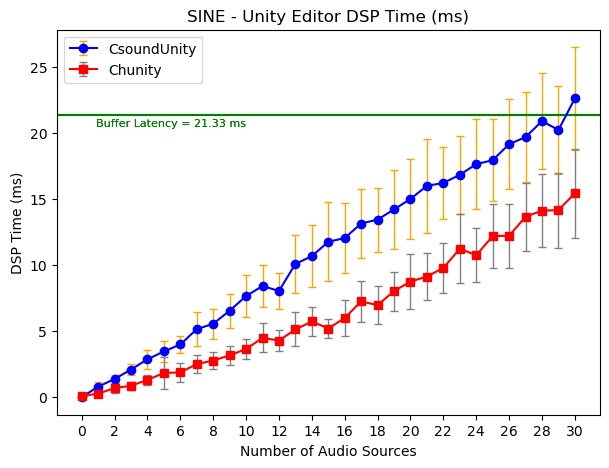

In [91]:
#plt.figure(figsize=(15, 8))
plt.figure(figsize=(7, 5))

folder = 'editor_data/sine_patch'

sound_engine = 'CsoundUnity'
date = '2024-03-04_11-15-51'
data_cs = Plot_CPU(folder, sound_engine, 'SINE - Unity Editor', date)

sound_engine = 'ChuckMainInstance'
date = '2024-03-04_11-19-53'
data_chuck = Plot_CPU(folder, sound_engine, 'SINE - Unity Editor', date, marker='s-', color_frame_time='red', ecolor_frame_time='grey')

# Set the legend labels
plt.legend(['CsoundUnity', 'Chunity'])

plt.xticks(ticks=range(len(data_cs.index))[::2], labels=data_cs['sources'][::2])


plt.show()

## Sine: Memory

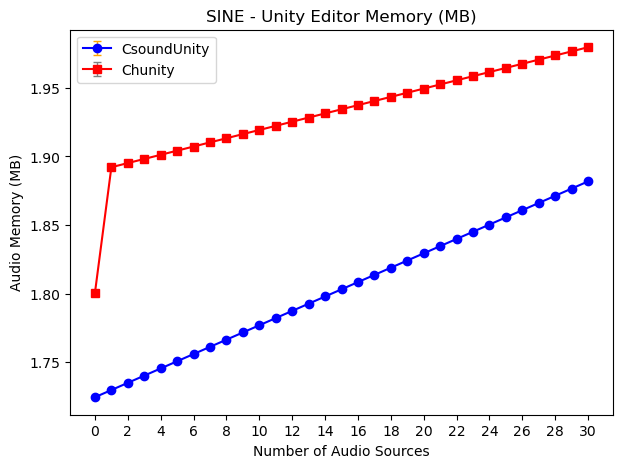

In [92]:
plt.figure(figsize=(7, 5))

folder = 'editor_data/sine_patch'

sound_engine = 'CsoundUnity'
date = '2024-03-04_11-15-51'
data_cs = Plot_Memory(folder, sound_engine, 'SINE - Unity Editor', date)

sound_engine = 'ChuckMainInstance'
date = '2024-03-04_11-19-53'
data_chuck = Plot_Memory(folder, sound_engine, 'SINE - Unity Editor', date, marker='s-', color_memory='red', ecolor_memory='grey')

# Set the legend labels
plt.legend(['CsoundUnity', 'Chunity'])

plt.xticks(ticks=range(len(data_cs.index))[::2], labels=data_cs['sources'][::2])


plt.show()

## Synthe: DSP Time

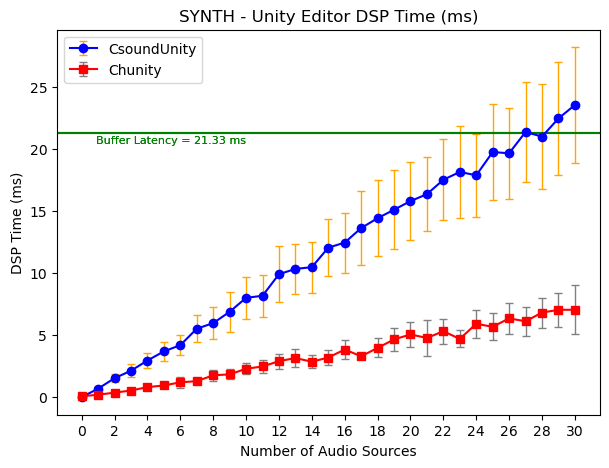

In [95]:
plt.figure(figsize=(7, 5))

folder = 'editor_data/simple_synthe'

sound_engine = 'CsoundUnity'
date = '2024-03-05_09-41-18'
data_cs = Plot_CPU(folder, sound_engine, 'SYNTH - Unity Editor', date)

sound_engine = 'ChuckMainInstance'
date = '2024-03-05_09-53-43'
data_chuck = Plot_CPU(folder, sound_engine, 'SYNTH - Unity Editor', date, marker='s-', color_frame_time='red', ecolor_frame_time='grey')

# Set the legend labels
plt.legend(['CsoundUnity', 'Chunity'])

plt.xticks(ticks=range(len(data_cs.index))[::2], labels=data_cs['sources'][::2])


plt.show()

## Synthe: Memory

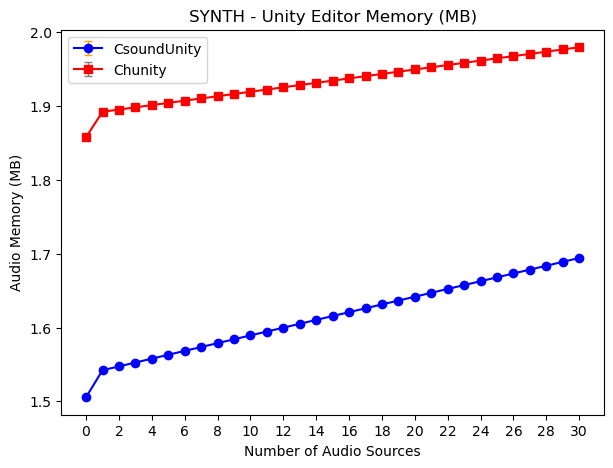

In [57]:
plt.figure(figsize=(7, 5))

folder = 'editor_data/simple_synthe'

sound_engine = 'CsoundUnity'
date = '2024-03-05_09-41-18'
data_cs = Plot_Memory(folder, sound_engine, 'SYNTH - Unity Editor', date)

sound_engine = 'ChuckMainInstance'
date = '2024-03-05_09-53-43'
data_chuck = Plot_Memory(folder, sound_engine, 'SYNTH - Unity Editor', date, marker='s-', color_memory='red', ecolor_memory='grey')

# Set the legend labels
plt.legend(['CsoundUnity', 'Chunity'])

plt.xticks(ticks=range(len(data_cs.index))[::2], labels=data_cs['sources'][::2])

plt.show()

## Hanging Processes
### Resource Leak - CPU

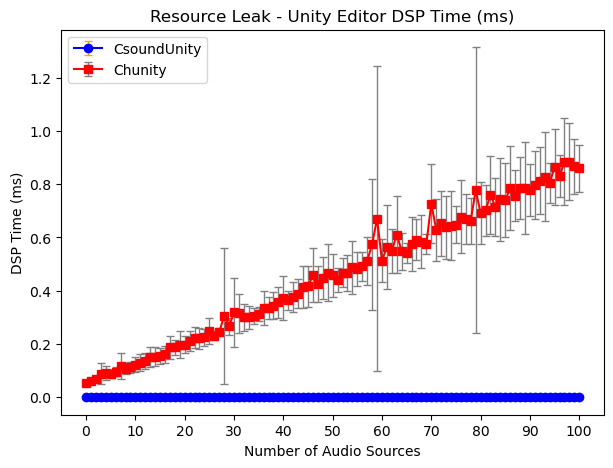

In [108]:
plt.figure(figsize=(7, 5))

folder = 'editor_data/hang'

sound_engine = 'CsoundUnity'
date = '2024-03-04_16-18-13'
data_cs = Plot_CPU(folder, sound_engine, 'Resource Leak - Unity Editor', date, drawBufferLimit=False)

sound_engine = 'ChuckMainInstance'
date = '2024-03-04_16-33-36'
data_chuck = Plot_CPU(folder, sound_engine, 'Resource Leak - Unity Editor', date, marker='s-', color_frame_time='red', ecolor_frame_time='grey', drawBufferLimit=False)

# Set the legend labels
plt.legend(['CsoundUnity', 'Chunity'])

plt.xticks(ticks=range(len(data_cs.index))[::10], labels=data_cs['sources'][::10])


plt.show()

### Memory Leak

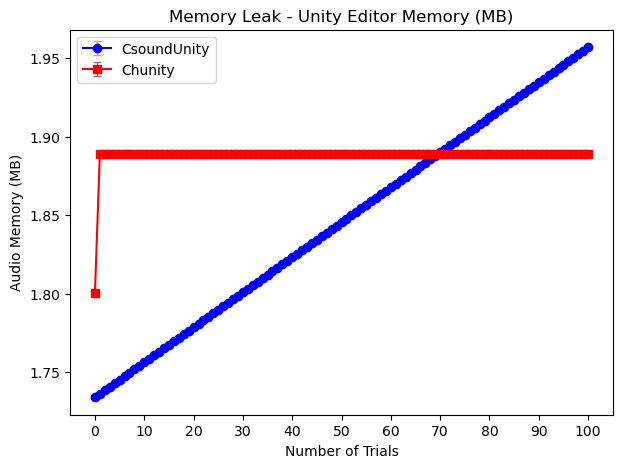

In [109]:
plt.figure(figsize=(7, 5))

folder = 'editor_data/hang'

sound_engine = 'CsoundUnity'
date = '2024-03-04_16-18-13'
data_cs = Plot_Memory(folder, sound_engine, 'Memory Leak - Unity Editor', date, xlabel='Number of Trials')

sound_engine = 'ChuckMainInstance'
date = '2024-03-04_16-33-36'
data_chuck = Plot_Memory(folder, sound_engine, 'Memory Leak - Unity Editor', date, xlabel='Number of Trials', marker='s-', color_memory='red', ecolor_memory='grey')

# Set the legend labels
plt.legend(['CsoundUnity', 'Chunity'])

plt.xticks(ticks=range(len(data_cs.index))[::10], labels=data_cs['sources'][::10])


plt.show()

# Meta Quest 3
## Sine: DSP Time

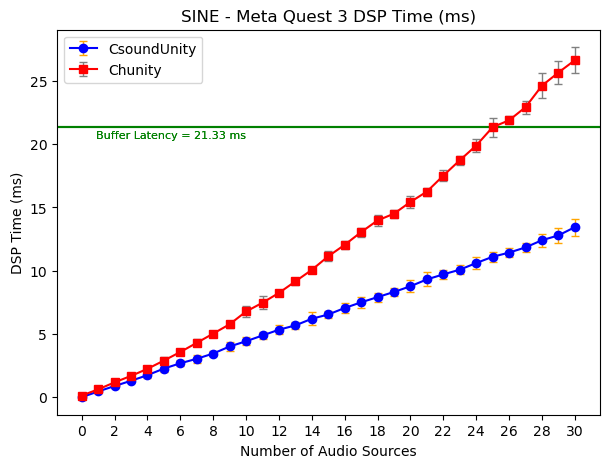

In [97]:
plt.figure(figsize=(7, 5))

folder = 'meta_quest_data/sine_patch'

sound_engine = 'CsoundUnity'
date = '2024-03-05_14-11-06'
data_cs = Plot_CPU(folder, sound_engine, 'SINE - Meta Quest 3', date)

sound_engine = 'ChuckMainInstance'
date = '2024-03-05_14-16-52'
data_chuck = Plot_CPU(folder, sound_engine, 'SINE - Meta Quest 3', date, marker='s-', color_frame_time='red', ecolor_frame_time='grey')

# Set the legend labels
plt.legend(['CsoundUnity', 'Chunity'])

plt.xticks(ticks=range(len(data_cs.index))[::2], labels=data_cs['sources'][::2])


plt.show()

# Sine: Memory

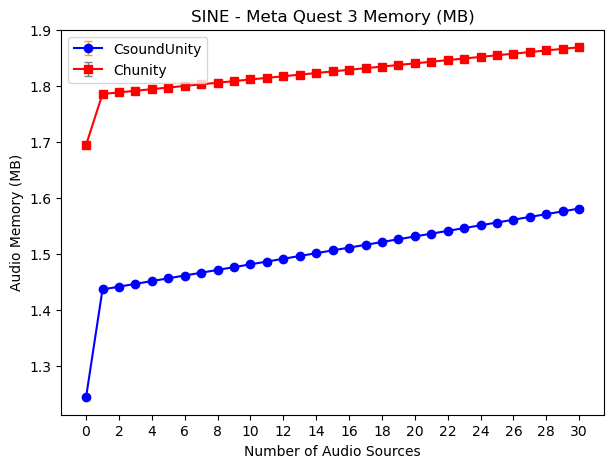

In [98]:
plt.figure(figsize=(7, 5))

folder = 'meta_quest_data/sine_patch'

sound_engine = 'CsoundUnity'
date = '2024-03-05_14-11-06'
data_cs = Plot_Memory(folder, sound_engine, 'SINE - Meta Quest 3', date)

sound_engine = 'ChuckMainInstance'
date = '2024-03-05_14-16-52'
data_chuck = Plot_Memory(folder, sound_engine, 'SINE - Meta Quest 3', date, marker='s-', color_memory='red', ecolor_memory='grey')

# Set the legend labels
plt.legend(['CsoundUnity', 'Chunity'])

plt.xticks(ticks=range(len(data_cs.index))[::2], labels=data_cs['sources'][::2])


plt.show()